# Installation
Run the cell below once at the beginning of each session. The output can then be cleared.

In [ ]:
!pip install se-lib --quiet

from selib import *


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.6/933.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 9.2 MB/s eta 0:00:00


# Discrete Event Modeling with se-lib – User's Guide

 ### July 7, 2025

 # Table of Contents
- [1. Overview and Getting Started](#Overview)
- [2. Defining Model Components](#Defining-Model-Components)
  - [2.1 Sources and Entities](#Sources-and-Entities)
  - [2.2 Servers](#Servers)
  - [2.3 Delays](#Delays)
  - [2.4 Termination Nodes](#Termination-Nodes)
- [3 Common Processes and Modeling Patterns](#Common-Processes-and-Modeling-Patterns)
  - [3.1 Single Server Queueing System](#31-single-server-queueing-system)
  - [3.2 Path Delay](#32-path-delay)
  - [3.3 Probabilistic Routing and Parallel Servers](#33-probabilistic-routing-and-parallel-servers)
  - [3.4 Capacity-Constrained Server](#34-capacity-constrained-server)
- [4. Visualizing Model Diagrams](#4-visualizing-model-diagrams)
- [5. Running a Simulation and Analyzing Output](#5-running-a-simulation-and-analyzing-output)
  - [5.1 Run Data](#51-run-data)
  - [5.2 Output Histograms](#52-output-histograms)

<a name="Overview"></a>
## 1. Overview and Getting Started

This user's guide describes constructing and simulating discrete event models using the Systems Engineering Library (se-lib). The discrete event modeling capability allows for simulation of systems described as networks consisting of nodes that are connected by paths for entity flow.  Simulation is event-driven with tracking of individual entities as they pass through the network of process nodes.

To begin, import se-lib and initialize a discrete event model.

```python
from selib import *
init_de_model()
```

This call prepares the model environment, sets up the simulation clock, and initializes the discrete event network structure.

---
<a name="Defining-Model-Components"></a>
## 2. Defining Model Components

A system model is described by defining nodes for sources, servers with queues, delays, and terminations. Entity path logic between nodes is also specified.

<a name="Sources-and-Entities"></a>
### 2.1 Sources and Entities

 Source nodes generate entities with desired timings. They are system entry points for each entity that represents a task, product, or unit that flows through the system.

```python
add_source(
    name="Arrival",
    entity_name="Car",
    num_entities=100,
    connections={'Charger': 1},
    interarrival_time="random.uniform(1, 5)"
)
```

The source generates entities of the given name, spaced by a specified interarrival time. The entity names and their sequential IDs can be used in model logic.
Connections define which node(s) the entity proceeds to with relative probabilities.  

In the above example entities only connect to a single next node ```Charger``` with a 100% probability.  An example for multiple connections to two parallel servers with 50% probability each would be:

```python
    connections={'Charger1': .5, 'Charger2': .5},
```

Note the path weights are relative to each other. Thus any value for a single path would suffice as 100%, and any two equal values would allocate 50% probability.  For example, ```connections={'Charger1': 50, 'Charger2': 50}``` or even ```connections={'Charger1': 1, 'Charger2': 1}``` will have the same probabilistc effect.

<a name="Servers"></a>
### 2.2 Servers

Servers represent resources with constrained capacity, where queues form before the servers.

```python
add_server(
    name="Charger",
    connections={"Exit": 1.0},
    service_time="random.uniform(2, 5)",
    capacity=1
)
```

Servers queue entities and delay them based on the service time expression. The capacity controls how many can be served concurrently.

<a name="Delays"></a>
### 2.3 Delays

Delays correspond to the travel times of entities
from one node to the next.  They hold entities for a fixed or variable time without queueing.

```python
add_delay(
    name="Payment Approval",
    connections={"Charger": 1.0},
    delay_time="2"
)
```

<a name="Termination-Nodes"></a>
### 2.4 Termination Nodes

Terminate nodes represent the path ends for entities where they are removed from the system.

```python
add_terminate(name="Exit")
```

---
<a name="Common-Processes-and-Modeling-Patterns"></a>
## 3 Common Processes and Modeling Patterns

The following examples illustrate common processes and discrete event modeling structures using se-lib.

###  3.1 Single Server Queueing System

This model demonstrates a basic single-server queue. Entities are generated at regular intervals and may experience waiting delays due to limited capacity at the server. The queue accumulates when entity arrivals exceed the server’s ability to process them.

The output from this will display the model diagram and default run output.

```python
import random as random

init_de_model()
add_source(
    name="Arrival",
    entity_name="Car",
    num_entities=100,
    connections={'Charger': 1},
    interarrival_time="random.uniform(1, 5)"
)
add_server(
    name="Charger",
    connections={"Leave": 1.0},
    service_time="random.uniform(1, 4)",
    capacity=1
)
add_terminate(name="Leave")
draw_model()
run_model()
```

![single_server_car_charger](https://github.com/se-lib/se-lib/raw/main/docs/figures/single_server_car_charger.svg)

```
2.0555141567824218: Car 1 entered from Arrival
2.0555141567824218: Car 1 Arrival -> Charger
2.0555141567824218: Car 1 requesting Charger resource
2.0555141567824218: Car 1 granted Charger resource waiting time 0.0
3.9530893974237076: Car 2 entered from Arrival
3.9530893974237076: Car 2 Arrival -> Charger
3.9530893974237076: Car 2 requesting Charger resource
5.885350790323626: Car 1 completed using Charger resource with service time 3.8298366335412037
5.885350790323626: Car 1 Charger -> Leave
5.885350790323626: Car 1 leaving system at Leave
5.885350790323626: Car 2 granted Charger resource waiting time 1.9322613928999184
...
```

### 3.2 Path Delay

Entities experience a fixed or variable delay before entering a node.

```python
init_de_model()
add_source("Source", "Entity", 10, {"Delay": 1.0}, "1")
add_delay("Delay", {"Server": 1.0}, "2")
add_server("Server", {"Terminate": 1.0}, "3")
add_terminate("Terminate")
draw_model("delayed_path")
run_model()
```

![delayed_path](https://github.com/se-lib/se-lib/raw/main/docs/figures/delayed_path.svg)

```
1: Entity 1 entered from Source
1: Entity 1 Source -> Delay
2: Entity 2 entered from Source
2: Entity 2 Source -> Delay
3: Entity 3 entered from Source
3: Entity 3 Source -> Delay
```

In this example the function calls do not include the parameter input names. This optional syntax shortcut requires that the inputs are in the standard calling order.

### 3.3 Probabilistic Routing and Parallel Servers

This model contains nondeterministic routing to parallel servers. After passing through a central node, entities are dispatched to downstream paths with user-defined probabilities. The relative frequencies of path usage are reflected in the defined routing weights.

```python
init_de_model()
add_source("Source", "Entity", 10, {"Router": 1.0}, "1")
add_server("Router", {"Server A": 0.6, "Server B": 0.4}, "1")
add_server("Server A", {"Sink": 1.0}, "2")
add_server("Server B", {"Sink": 1.0}, "2")
add_terminate("Sink")
draw_model("path_routing")
run_model()
```
![path_routing](https://github.com/se-lib/se-lib/raw/main/docs/figures/path_routing.svg)


```
1: Entity 1 entered from Source
1: Entity 1 Source -> Router
1: Entity 1 requesting Router resource
1: Entity 1 granted Router resource waiting time 0
2: Entity 2 entered from Source
2: Entity 2 Source -> Router
2: Entity 2 requesting Router resource
2: Entity 1 completed using Router resource with service time 1
2: Entity 1 Router -> Server B
...
```

### 3.4 Capacity-Constrained Server

This model demonstrates the effect of constrained concurrency. A limited-capacity server processes multiple entities in parallel, up to the defined maximum. It reflects real-world constraints such as limited personnel, tools, or workstations.

```python
init_de_model()
add_source("Source", "Entity", 10, {"SharedResource": 1.0}, "1")
add_server("SharedResource", {"Exit": 1.0}, "5", capacity=2)
add_terminate("Exit")
draw_model("capacity_2")
run_model()

```

---
## 4. Visualizing Model Diagrams

A diagram of the model structure can be rendered using the ```draw_model``` function.

```python
draw_model(filename="single_server_car_charger", format="svg")
```

![single_server_car_charger](https://github.com/se-lib/se-lib/raw/main/docs/figures/single_server_car_charger.svg)

This produces a Graphviz-based model layout showing sources, servers, delays, and terminations along with their connections. The default format is svg and may be set to other supported output types including, pdf, png and jpeg files.  The format parameter in this example can be omitted since svg is the default.

---

<a id="running"></a>
## 5. Running a Simulation and Analyzing Output

Once all model components are defined, execute the simulation with ```run_model()```.  Entities are generated and tracked as they move through the network, and statistics are collected at each node. The default behavior is that verbose output will be displayed for each event and resulting model data will be shown.

```python
run_model()
```

```2.0555141567824218: Car 1 entered from Arrival
2.0555141567824218: Car 1 Arrival -> Charger
2.0555141567824218: Car 1 requesting Charger resource
2.0555141567824218: Car 1 granted Charger resource waiting time 0.0
3.9530893974237076: Car 2 entered from Arrival
...
```

The verbose output can be turned off with the ``verbose`` parameter.
```python
run_model(verbose=False)
```

### 5.1 Run Data
The ```run_model()``` function returns a tuple of model data and entity data for post-processing after execution. Model data includes node-level statistics for waiting times, service durations, resource utilization.  Entity data includes nodes visited, arrival and departure times for each entity ID.

The results are returned as a tuple and can be captured in dictionaries by naming them:

```python
model_data, entity_data = run_model()
```
These dictionaries can be examined, plotted, or exported depending on analysis needs.

```
print(model_data)
```

```
{'incoming_cars': {'type': 'source',
  'entity_name': 'Car',
  'num_entities': 50,
  'connections': {'charger': 0.7, 'impatient_cars': 0.3},
  'interarrival_time': 'np.random.exponential(5)',
  'arrivals': [1.8518275246814762,
   2.8837972333170807,
   3.2180364021037855,
   7.772066998169806,
...
'charger': {'type': 'server',
  'resource': <simpy.resources.resource.Resource at 0x7eecdb78d990>,
  'connections': {'payment': 1},
  'service_time': 'np.random.uniform(0, 16)',
  'waiting_times': [0.0,
   7.445018946036789,
   0.0,
   4.571154552428116,
   8.16315227890377,
   11.644193625248807,
   17.90869326875388,
   23.15034857718623,
   21.854958198126376,
   26.63050101289388,
   21.39761772342264,
   34.4534979183592,
   31.324463510453114,
   23.829072039820502,
   20.01940237435413,
   13.518156192205794,
   12.719070576090331,
...
```
Run statistics on nodes can be accessed in the output dictionary.  From the run output the waiting times for a server queue can be accessed with the following which provides a list of values.  For each node, se-lib captures the entity waiting times, service times, and utilization.

```
model_data['charger']['waiting_times']
```

```
[0.0,
 7.445018946036789,
 0.0,
 4.571154552428116,
...
```

Entity data contains event time data for each entity traversing through the network.

```
print(entity_data)
```

```
{1: {'arrival': 1.8518275246814762,
  'nodes': [('charger', 10.663055348140574),
   ('payment', 13.328187581559387),
   ('served_cars', 13.328187581559387)],
  'departure': 13.328187581559387},
 2: {'arrival': 2.8837972333170807,
  'nodes': [('impatient_cars', 2.8837972333170807)],
  'departure': 2.8837972333170807},
 3: {'arrival': 3.2180364021037855,
  'nodes': [('charger', 11.254405882251344),
   ('payment', 13.981810162773758),
   ('served_cars', 13.981810162773758)],
  'departure': 13.981810162773758},
...
```

### 5.2 Output Histograms

The run output can be sent for plotting histograms with ```plot_histogram()```.  It takes a lists which can be specified from the run output data.

```
plot_histogram(model_data['charger']['service_times'], xlabel="Charger Service Time")
```

<img src="https://github.com/se-lib/se-lib/raw/main/docs/figures/charger_service_times.png"
     alt="charger_service_times"
     width="400px">


---

## 7. Appendix A - Function Reference


*se-lib* provides two complementary interfaces for building and running discrete event models:

- **Procedural API** – A function-based interface that uses a single shared model instance behind the scenes.
- **Object-Oriented API** – A class-based interface that supports multiple model instances, encapsulated data, and better modularization.

The APIs offer the same modeling capabilities. The procedural interface is often more convenient for quick scripting but limited. The object-oriented interface is more scalable for larger simulations and programmatic reuse.

### Procedural API
These functions provide a procedural interface for discrete event modeling. A single instance of a model is implicit when using them.

### `init_de_model()`
Initializes a discrete event simulation model. Clears any existing structure and sets up a SimPy environment.

### `add_source(name, entity_name, num_entities, connections, interarrival_time)`
Defines a source node that generates entities with the given interarrival pattern.

### `add_server(name, connections, service_time, capacity=1)`
Adds a server with queueing behavior and optional parallel capacity.

### `add_delay(name, connections, delay_time)`
Adds a delay node that holds entities for a fixed or random duration.

### `add_terminate(name)`
Adds a termination node where entities exit the system.

### `run_model(verbose=True)`
Runs the model as a simulation. Returns model and entity data.

### `draw_model_diagram(filename=None, format="svg")`
Draws the model diagram using Graphviz.

These functions internally use a singleton `DiscreteEventModel` instance for compatibility.  The `DiscreteEventModel` class is described in the next section for the Object-Oriented API.

---

### `DiscreteEventModel` Class (Object-Oriented API)

A class for creating and simulating discrete event models.  For advanced use, `DiscreteEventModel` can be instantiated irectly. This allows the creation of multiple models, encapsulation of simulation logic in classes, and building of reusable components.

---

### `DiscreteEventModel()`
Creates a new empty discrete event model.

**Example**:
```python
model = DiscreteEventModel()
```

---

### `.add_server(name, connections, service_time, capacity=1)`
Adds a server node to the model.

**Args**:
- `name`: Name of the server.
- `connections`: Dictionary of next-node probabilities.
- `service_time`: Constant or expression for service duration.
- `capacity`: Number of resources (default is 1).

**Example**:
```python
model.add_server("Server1", {"Delay1": 1.0}, "random.expovariate(1.0)")
```

---

### `.add_delay(name, connections, delay_time)`
Adds a delay node to the model.

**Args**:
- `name`: Name of the delay.
- `connections`: Dictionary of next-node probabilities.
- `delay_time`: Duration expression.

---

### `.add_source(name, entity_name, num_entities, connections, interarrival_time)`
Adds a source node to the model.

**Args**:
- `name`: Name of the source node.
- `entity_name`: Label for generated entities.
- `num_entities`: Count of entities to generate.
- `connections`: Next-node probabilities.
- `interarrival_time`: Interval expression.

---

### `.add_terminate(name)`
Adds a termination node for entities.

**Args**:
- `name`: Node label.

---

### `.run(verbose=True)`
Runs the simulation and returns results.

**Args**:
- `verbose`: Print simulation events if True.

**Returns**:
- `network`, `entity_data`: Simulation structure and result logs.

**Example**:
```python
results = model.run(verbose=False)
```

---

### `.draw(filename=None, format='svg')`
Draws the model using Graphviz.

**Args**:
- `filename`: Optional name to save.
- `format`: Output format (e.g. 'svg', 'png').

---






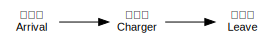

({'Arrival': {'type': 'source',
   'entity_name': 'Car',
   'num_entities': 100,
   'connections': {'Charger': 1},
   'interarrival_time': 'random.uniform(1, 5)',
   'arrivals': [3.9557777432401564,
    8.814843092889763,
    10.813227885148716,
    13.79799705015963,
    14.814397060883065,
    18.00309749417525,
    21.711703135336087,
    24.58846503976881,
    26.06268412901332,
    27.406985874404675,
    29.85238801714588,
    32.70361966665332,
    37.468464353669894,
    40.9975039238311,
    44.85524648071532,
    46.241009304634574,
    47.45213277664892,
    51.21638897375175,
    52.938468420889336,
    54.538936424869775,
    58.205805303597835,
    60.27222335517036,
    61.708963801440575,
    65.19219649162785,
    66.8090613381437,
    68.23454971984657,
    69.75548032418354,
    74.01934134898903,
    78.89133378107782,
    83.26985123936667,
    86.22700176973402,
    87.88907124929327,
    92.73758238180558,
    94.55162607846317,
    97.79946325323084,
    101.964

In [ ]:
import random as random

init_de_model()
add_source(
    name="Arrival",
    entity_name="Car",
    num_entities=100,
    connections={'Charger': 1},
    interarrival_time="random.uniform(1, 5)"
)
add_server(
    name="Charger",
    connections={"Leave": 1.0},
    service_time="random.uniform(1, 4)",
    capacity=1
)
add_terminate(name="Leave")
draw_model()
run_model(verbose=False)

# Single Server Queue Systems

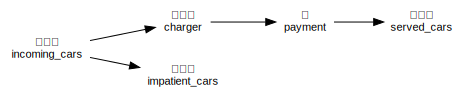

0.8886210183758969: Car 1 entered from incoming_cars
0.8886210183758969: Car 1 incoming_cars -> charger
0.8886210183758969: Car 1 requesting charger resource 
0.8886210183758969: Car 1 granted charger resource waiting time 0.0
1.1357974171850282: Car 1 completed using charger resource with service time 0.24717639880913134
1.1357974171850282: Car 1 charger -> payment
2.987762885811553: Car 1 delayed 1.8519654686265246 at payment
2.987762885811553: Car 1 payment -> served_cars
2.987762885811553: Car 1 leaving system at served_cars 
3.3687445930766593: Car 2 entered from incoming_cars
3.3687445930766593: Car 2 incoming_cars -> impatient_cars
3.3687445930766593: Car 2 leaving system at impatient_cars 
3.6459674945242635: Car 3 entered from incoming_cars
3.6459674945242635: Car 3 incoming_cars -> charger
3.6459674945242635: Car 3 requesting charger resource 
3.6459674945242635: Car 3 granted charger resource waiting time 0.0
7.5277406621934855: Car 3 completed using charger resource with se

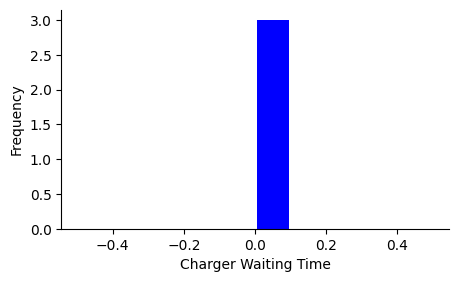

In [ ]:
# @title Electric Car Charging System

from selib import *

init_de_model()

add_source('incoming_cars',
           entity_name="Car",
           num_entities = 5,
           connections={'charger': .7, 'impatient_cars': .3},
           interarrival_time='np.random.uniform(0, 5)')

add_server(name='charger',
           connections={'payment': 1},
           service_time='np.random.uniform(0, 10)',
           capacity = 1)

add_delay(name='payment',
           delay_time = 'np.random.uniform(1, 3)',
           connections={'served_cars': 1},)

add_terminate('served_cars')
add_terminate('impatient_cars')

draw_model()
model_data, entity_data = run_model()

plot_histogram(model_data['charger']['waiting_times'], xlabel="Charger Waiting Time")

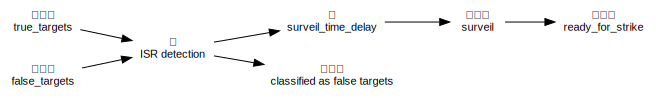

In [ ]:
init_de_model()

add_source('true_targets',
           entity_name="true_target",
           num_entities = 2,
           connections={'ISR detection': 1},
           interarrival_time='0')

add_source('false_targets',
           entity_name="false_target",
           num_entities = 2,
           connections={'ISR detection': 1},
           interarrival_time='0')

add_delay(name='ISR detection',
           delay_time = 'np.random.uniform(1, 3)',
           connections={'surveil_time_delay': ".8 if entity_name=='true_target' else .4", 'classified as false targets': ".6 if entity_name=='false_target' else .2"},)

add_delay(name='surveil_time_delay',
           delay_time = 'np.random.uniform(20, 25)',
           connections={'surveil': 1},)

add_server(name='surveil',
           connections={' ready_for_strike': 1},
           service_time='np.random.uniform(0, 16)',
           capacity = 2)

add_terminate(' ready_for_strike')
add_terminate('classified as false targets')

draw_model_diagram()

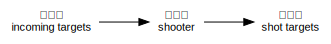

2.8586851130422453: target 1 entered from incoming targets
2.8586851130422453: target 1 incoming targets -> shooter
2.8586851130422453: target 1 requesting shooter resource 
2.8586851130422453: target 1 granted shooter resource waiting time 0.0
3.9659305389439847: target 2 entered from incoming targets
3.9659305389439847: target 2 incoming targets -> shooter
3.9659305389439847: target 2 requesting shooter resource 
4.07123234520031: target 1 completed using shooter resource with service time 1.212547232158065
4.07123234520031: target 1 shooter -> shot targets
4.07123234520031: target 1 leaving system at shot targets 
4.07123234520031: target 2 granted shooter resource waiting time 0.10530180625632557
4.556114091645943: target 3 entered from incoming targets
4.556114091645943: target 3 incoming targets -> shooter
4.556114091645943: target 3 requesting shooter resource 
5.095498093121697: target 2 completed using shooter resource with service time 1.0242657479213866
5.095498093121697: ta

In [ ]:
# @title Target Shooter System with Conditional Shooting Distributions

from selib import *

# default input parameters
num_shooters = 1
num_targets = 10
weapons_technology = "Normal"

if weapons_technology == "High": shooting_time = 'np.random.normal(.8, .2)'
if weapons_technology == "Normal": shooting_time = 'np.random.normal(1, .3)'

init_de_model()
add_source('incoming targets',
           entity_name="target",
           num_entities = num_targets,
           connections={'shooter': 1},
           interarrival_time='np.random.exponential(2)')

add_server(name='shooter',
           connections={'shot targets': 1},
           service_time=shooting_time,
           capacity = num_shooters)

add_terminate('shot targets')

draw_model_diagram(filename="target_shooter_model_diagram", format='svg')

model_data, target_entity_data = run_model()
print('Model data \n', model_data)
print('Target data \n',target_entity_data)

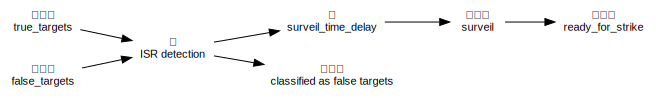

0: true_target 1 entered from true_targets
0: true_target 1 true_targets -> ISR detection
0: true_target 2 entered from true_targets
0: true_target 2 true_targets -> ISR detection
0: false_target 1 entered from false_targets
0: false_target 1 false_targets -> ISR detection
0: false_target 2 entered from false_targets
0: false_target 2 false_targets -> ISR detection
1.2627269903961706: true_target 1 delayed 1.2627269903961706 at ISR detection
1.2627269903961706: true_target 1 ISR detection -> surveil_time_delay
1.2870743916233236: false_target 2 delayed 1.2870743916233236 at ISR detection
1.2870743916233236: false_target 2 ISR detection -> classified as false targets
1.2870743916233236: false_target 2 leaving system at classified as false targets 
1.4206462327841933: false_target 1 delayed 1.4206462327841933 at ISR detection
1.4206462327841933: false_target 1 ISR detection -> classified as false targets
1.4206462327841933: false_target 1 leaving system at classified as false targets 
2.

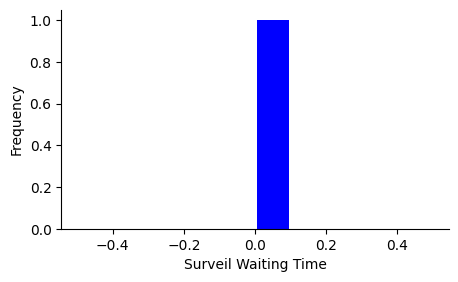

In [ ]:
# @title UAS Model with Multiple Sources and Conditional Paths

from selib import *

"""
ISR Detection Confusion Matrix
|                        | Predicted: Target         | Predicted: No Target       |
|------------------------|---------------------------|----------------------------|
| Actual: Target         | True Positive (TP)  80%   | False Negative (FN) 20%    |
| Actual: No Target      | False Positive (FP) 40%   | True Negative (TN) 60%     |
"""

init_de_model()

add_source('true_targets',
           entity_name="true_target",
           num_entities = 2,
           connections={'ISR detection': 1},
           interarrival_time='0')

add_source('false_targets',
           entity_name="false_target",
           num_entities = 2,
           connections={'ISR detection': 1},
           interarrival_time='0')

add_delay(name='ISR detection',
           delay_time = 'np.random.uniform(1, 3)',
           connections={'surveil_time_delay': ".8 if entity_name=='true_target' else .4", 'classified as false targets': ".6 if entity_name=='false_target' else .2"},)

add_delay(name='surveil_time_delay',
           delay_time = 'np.random.uniform(20, 25)',
           connections={'surveil': 1},)

add_server(name='surveil',
           connections={' ready_for_strike': 1},
           service_time='np.random.uniform(2, 10)',
           capacity = 2)

add_terminate(' ready_for_strike')
add_terminate('classified as false targets')

draw_model()

model_data, entity_data = run_model()
plot_histogram(model_data['surveil']['waiting_times'], xlabel="Surveil Waiting Time")

# Multiple Server Queue Systems

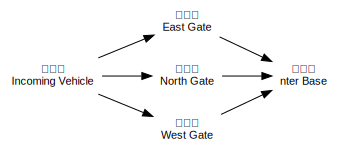

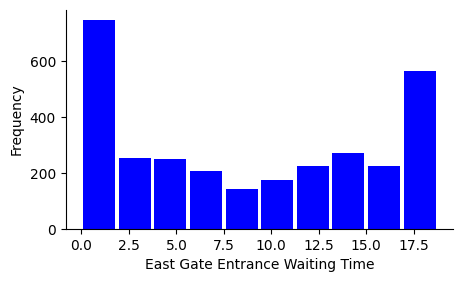

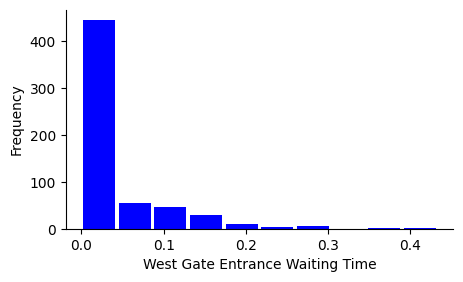

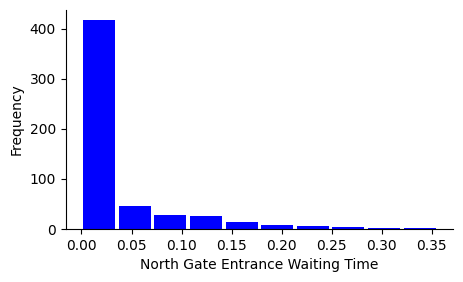

In [ ]:
# @title Miramar Security Gate Model with Custom Arrival Function

from selib import *
# TWO SERVERS; Vehicles entering base via East Gate simulation
# Assumption 1) 3100 vehicles enter the gate over the course of 240 minutes;
# Assumption 2) Proccessing at gate takes between 6 and 30 seconds; uniform distribution
# Assumption 3) 2 Lanes with 2 servers

# fitted polynomial equation to incoming traffic pattern in morning:
# poly1d([-4.61444588e-08,  2.21493402e-05, -4.44111906e-03,  4.27967576e-01, 5.48756248e+00])

init_de_model()

add_source('Incoming Vehicle',
           entity_name="Vehicle",
           num_entities=4200,
           connections={'East Gate': 0.74, 'North Gate': 0.12, 'West Gate': .14},
           interarrival_time='1/(-4.61444588e-08 * arrival_time**4 + 2.21493402e-05 * arrival_time**3 + -4.44111906e-03 * arrival_time**2 + 4.27967576e-01 * arrival_time + 5.48756248)')

add_server(name='East Gate',
           connections={'Enter Base': 1},
           service_time='np.random.uniform(.1, .2)',
           capacity=2)

add_server(name='North Gate',
           connections={'Enter Base': 1},
           service_time='np.random.uniform(.1, .2)',
           capacity=1)

add_server(name='West Gate',
           connections={'Enter Base': 1},
           service_time='np.random.uniform(.1, .2)',
           capacity=1)

add_terminate('Enter Base')

draw_model()

model_data, entity_data = run_model(verbose=False)
plot_histogram(model_data['East Gate']['waiting_times'], xlabel="East Gate Entrance Waiting Time")
plot_histogram(model_data['West Gate']['waiting_times'], xlabel="West Gate Entrance Waiting Time")
plot_histogram(model_data['North Gate']['waiting_times'], xlabel="North Gate Entrance Waiting Time")




In [ ]:
# @title Miramar Security Gate Model Monte Carlo Analysis
"""
Vehicles entering base via East Gate simulation
Assumption 1) 3100 vehicles enter the gate over the course of 240 minutes; exponential distribution is 0.077419 correct??
Assumption 2) Processing at gate takes between 6 and 12 seconds; uniform distribution
"""

from selib import *
import numpy as np

def multi_gate_model(east_num_servers, north_num_servers, west_num_servers):
    init_de_model()
    add_source('Incoming Vehicle',
           entity_name="Vehicle",
           num_entities=4200,
           connections={'East Gate': 0.74, 'North Gate': 0.12, 'West Gate': .14},
           interarrival_time='1/(-4.61444588e-08 * arrival_time**4 + 2.21493402e-05 * arrival_time**3 + -4.44111906e-03 * arrival_time**2 + 4.27967576e-01 * arrival_time + 5.48756248)')

    add_server(name='East Gate',
           connections={'Enter Base': 1},
           service_time='np.random.uniform(.1, .5)',
           capacity=east_num_servers)

    add_server(name='North Gate',
           connections={'Enter Base': 1},
           service_time='np.random.uniform(.1, .5)',
           capacity=north_num_servers)

    add_server(name='West Gate',
           connections={'Enter Base': 1},
           service_time='np.random.uniform(.1, .5)',
           capacity=west_num_servers)

    add_terminate('Enter Base')
    model_data, entity_data = run_model(verbose=False)
    return model_data, entity_data

# Define simulation parameters
num_runs = 5
east_num_servers_range = [2, 3, 4, 5]
north_num_servers_range = [1, 1, 1, 1]
west_num_servers_range = [1, 1, 1, 1]

# Monte Carlo simulation to collect average waiting times for multiple runs and server counts
east_scenario_average_waiting_times = [] # list of lists for each scenario
north_scenario_average_waiting_times = []
west_scenario_average_waiting_times = []

# Monte Carlo simulation
for east_servers, north_servers, west_servers in zip(east_num_servers_range, north_num_servers_range, west_num_servers_range):
    east_run_times = []
    north_run_times = []
    west_run_times = []

    for run in range(num_runs):
        model_data, entity_data = multi_gate_model(east_servers, north_servers, west_servers)

        east_run_times.append(np.mean(model_data['East Gate']['waiting_times']))
        north_run_times.append(np.mean(model_data['North Gate']['waiting_times']))
        west_run_times.append(np.mean(model_data['West Gate']['waiting_times']))

    east_scenario_average_waiting_times.append(np.mean(east_run_times))
    north_scenario_average_waiting_times.append(np.mean(north_run_times))
    west_scenario_average_waiting_times.append(np.mean(west_run_times))

# Display the results
print("East Scenario Average Waiting Times:", east_run_times)
print("North Scenario Average Waiting Times:", north_scenario_average_waiting_times)
print("West Scenario Average Waiting Times:", west_scenario_average_waiting_times)

East Scenario Average Waiting Times: [np.float64(0.13114115866028533), np.float64(0.07377625851078921), np.float64(0.06082683628303332), np.float64(0.07839881161357481), np.float64(0.0790858124910674)]
North Scenario Average Waiting Times: [np.float64(0.272040235752879), np.float64(0.5251680405540615), np.float64(0.4460269882839053), np.float64(0.38730407759018526)]
West Scenario Average Waiting Times: [np.float64(1.1985885628650872), np.float64(0.7220738862753254), np.float64(0.867966657339814), np.float64(0.5981511327828296)]


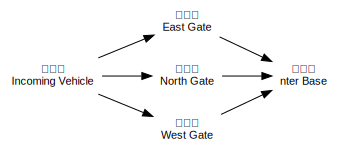

In [ ]:
draw_model()

Streaming output truncated to the last 5000 lines.
427.2540109509053: Vehicle 3484 leaving system at Enter Base 
427.26212266253947: Vehicle 3489 entered from Incoming Vehicle
427.26212266253947: Vehicle 3489 Incoming Vehicle -> East Gate
427.26212266253947: Vehicle 3489 requesting East Gate resource 
427.26212266253947: Vehicle 3489 granted East Gate resource waiting time 0.0
427.26447346552123: Vehicle 3479 completed using East Gate resource with service time 0.40495379705194856
427.26447346552123: Vehicle 3479 East Gate -> Enter Base
427.26447346552123: Vehicle 3479 leaving system at Enter Base 
427.3003411164116: Vehicle 3486 completed using East Gate resource with service time 0.1991700934513465
427.3003411164116: Vehicle 3486 East Gate -> Enter Base
427.3003411164116: Vehicle 3486 leaving system at Enter Base 
427.3158091260071: Vehicle 3490 entered from Incoming Vehicle
427.3158091260071: Vehicle 3490 Incoming Vehicle -> East Gate
427.3158091260071: Vehicle 3490 requesting East 

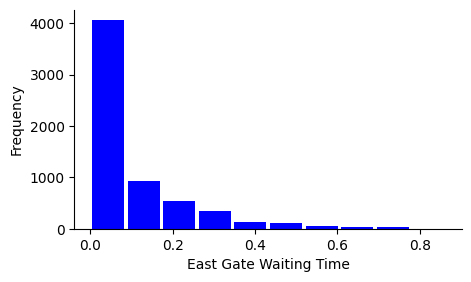

In [ ]:
model_data, entity_data = run_model()
plot_histogram(model_data['East Gate']['waiting_times'], xlabel="East Gate Waiting Time")

In [ ]:
model_data

{'Incoming Vehicle': {'type': 'source',
  'entity_name': 'Vehicle',
  'num_entities': 4200,
  'connections': {'East Gate': 0.74, 'North Gate': 0.12, 'West Gate': 0.14},
  'interarrival_time': '1/(-4.61444588e-08 * arrival_time**4 + 2.21493402e-05 * arrival_time**3 + -4.44111906e-03 * arrival_time**2 + 4.27967576e-01 * arrival_time + 5.48756248)',
  'arrivals': [0.18223027139000336,
   0.3619117535033469,
   0.5391580028107119,
   0.7140743942045803,
   0.8867589243840572,
   1.0573029164494085,
   1.2257916401747992,
   1.3923048599861596,
   1.5569173206932736,
   1.7196991794136671,
   1.8807163908055824,
   2.040031051639972,
   2.197701709841508,
   2.3537836423802685,
   2.508329105770683,
   2.6613875624100265,
   2.81300588554712,
   2.9632285452985463,
   3.112097777812802,
   3.2596537394129674,
   3.4059346473178564,
   3.550976908343921,
   3.694815236820137,
   3.837482762801463,
   3.9790111315395658,
   4.119430595059474,
   4.258770096595078,
   4.397057348552938,
   4.5

# Object Oriented Models

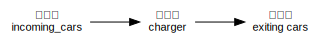

1: Car 1 entered from incoming_cars
1: Car 1 incoming_cars -> charger
1: Car 1 requesting charger resource 
1: Car 1 granted charger resource waiting time 0
2: Car 2 entered from incoming_cars
2: Car 2 incoming_cars -> charger
2: Car 2 requesting charger resource 
2.5: Car 1 completed using charger resource with service time 1.5
2.5: Car 1 charger -> exiting cars
2.5: Car 1 leaving system at exiting cars 
2.5: Car 2 granted charger resource waiting time 0.5
3: Car 3 entered from incoming_cars
3: Car 3 incoming_cars -> charger
3: Car 3 requesting charger resource 
4: Car 4 entered from incoming_cars
4: Car 4 incoming_cars -> charger
4: Car 4 requesting charger resource 
4.0: Car 2 completed using charger resource with service time 1.5
4.0: Car 2 charger -> exiting cars
4.0: Car 2 leaving system at exiting cars 
4.0: Car 3 granted charger resource waiting time 1.0
5: Car 5 entered from incoming_cars
5: Car 5 incoming_cars -> charger
5: Car 5 requesting charger resource 
5.5: Car 3 comple

({'incoming_cars': {'type': 'source',
   'entity_name': 'Car',
   'num_entities': 5,
   'connections': {'charger': 1},
   'interarrival_time': '1',
   'arrivals': [1, 2, 3, 4, 5]},
  'charger': {'type': 'server',
   'resource': <simpy.resources.resource.Resource at 0x7ad7e08629c0>,
   'connections': {'exiting cars': 1},
   'service_time': '1.5',
   'waiting_times': [0, 0.5, 1.0, 1.5, 2.0],
   'service_times': [1.5, 1.5, 1.5, 1.5, 1.5],
   'capacity': 1,
   'resource_busy_time': 7.5,
   'resource_utilization': 0.8823529411764706},
  'exiting cars': {'type': 'terminate', 'connections': {}}},
 {1: {'arrival': 1,
   'nodes': [('charger', 2.5), ('exiting cars', 2.5)],
   'departure': 2.5},
  2: {'arrival': 2,
   'nodes': [('charger', 4.0), ('exiting cars', 4.0)],
   'departure': 4.0},
  3: {'arrival': 3,
   'nodes': [('charger', 5.5), ('exiting cars', 5.5)],
   'departure': 5.5},
  4: {'arrival': 4,
   'nodes': [('charger', 7.0), ('exiting cars', 7.0)],
   'departure': 7.0},
  5: {'arrival'

In [ ]:
# @title OO electric car charging systemsource

from selib import *

model = DiscreteEventModel()
model.add_source('incoming_cars',
           entity_name="Car",
           num_entities = 5,
           connections={'charger': 1},
           interarrival_time='1')
model.add_server(name='charger',
           connections={'exiting cars': 1},
           service_time='1.5',
           capacity = 1)
model.add_terminate(name='exiting cars')

model.draw_model()
model.run_model()